In [ ]:
# Loading required libraries and functions
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input


In [ ]:
# Loading data and preprocessing images according to VGGNet requirements
# Creating data batches

labels = ['Flooding', 'No Flooding']
train_path = '/content/drive/MyDrive/DATA270/data_1/train'
valid_path = '/content/drive/MyDrive/DATA270/data_1/valid'
test_path = '/content/drive/MyDrive/DATA270/data_1/test'
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
#Loading pre-trained lightweight mobilenet image classifier
# mobile = tf.keras.applications.vgg16.vgg16(weights='imagenet', include_top=False)
from keras.applications.vgg16 import VGG16
    # load the model
mobile = VGG16()  

# mobile.summary()

553467096/553467096 [==============================] - 24s 0us/step


In [ ]:
x = mobile.layers[-12].output
x

<KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'block4_conv1')>

In [ ]:
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
output = Dense(units=2, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=mobile.input, outputs=output)

In [ ]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', precision_m,f1_m,recall_m])

In [ ]:
history = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=20,
          verbose=2
)

Epoch 1/20
60/60 - 681s - loss: 95.6569 - accuracy: 0.5450 - precision_m: 0.5282 - f1_m: 0.6271 - recall_m: 0.7950 - val_loss: 17.9750 - val_accuracy: 0.5850 - val_precision_m: 0.5753 - val_f1_m: 0.6295 - val_recall_m: 0.7000 - 681s/epoch - 11s/step
Epoch 2/20
60/60 - 12s - loss: 9.5587 - accuracy: 0.6333 - precision_m: 0.5857 - f1_m: 0.6522 - recall_m: 0.7517 - val_loss: 3.2971 - val_accuracy: 0.7150 - val_precision_m: 0.5633 - val_f1_m: 0.6896 - val_recall_m: 0.8950 - 12s/epoch - 198ms/step
Epoch 3/20
60/60 - 12s - loss: 4.3070 - accuracy: 0.6717 - precision_m: 0.6225 - f1_m: 0.6107 - recall_m: 0.6317 - val_loss: 2.7346 - val_accuracy: 0.7000 - val_precision_m: 0.6320 - val_f1_m: 0.6810 - val_recall_m: 0.7550 - 12s/epoch - 199ms/step
Epoch 4/20
60/60 - 12s - loss: 3.2962 - accuracy: 0.6950 - precision_m: 0.6118 - f1_m: 0.6533 - recall_m: 0.7167 - val_loss: 1.9320 - val_accuracy: 0.6600 - val_precision_m: 0.5871 - val_f1_m: 0.6920 - val_recall_m: 0.8550 - 12s/epoch - 199ms/step
Epoch 

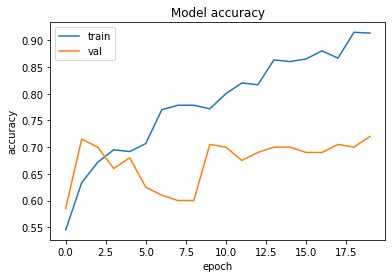

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

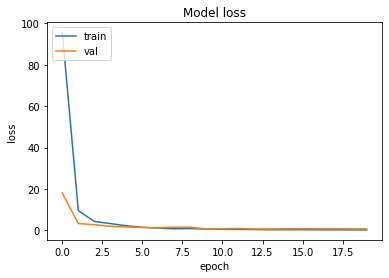

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

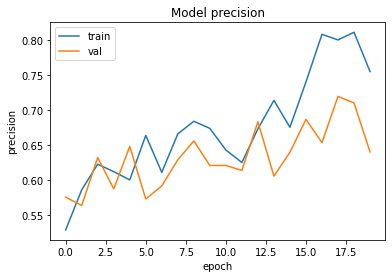

In [ ]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

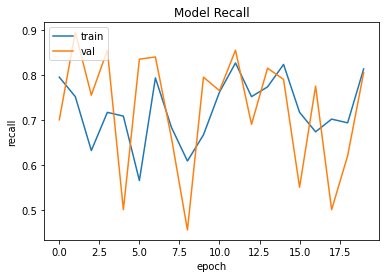

In [ ]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Model Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

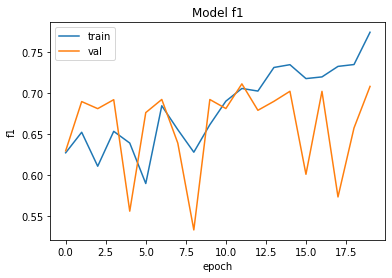

In [ ]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Saving and loading our trained for future use

model.save("fine_tuned_flood_detection_model")

In [ ]:
import warnings
warnings.filterwarnings('always') 

In [ ]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches,steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
recall =recall_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Pring precision, F1 score and accuracy of our model
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
# print('Loss: ', loss)

Precision:  0.7307692307692307
F1 Score:  0.6705882352941176
Recall:  0.6195652173913043
Accuracy:  0.72


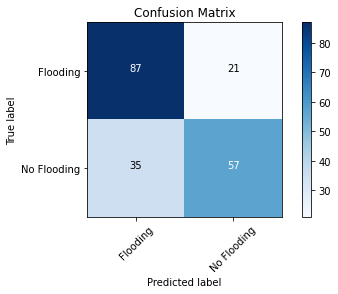

In [ ]:
# Confusion Matrix 
test_batches.class_indices
cm_plot_labels = ['Flooding','No Flooding']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
# Prepare image for mobilenet prediction

def preprocess_image(file):
    img_path = '/content/drive/MyDrive/DATA270/data_1/train/flood'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

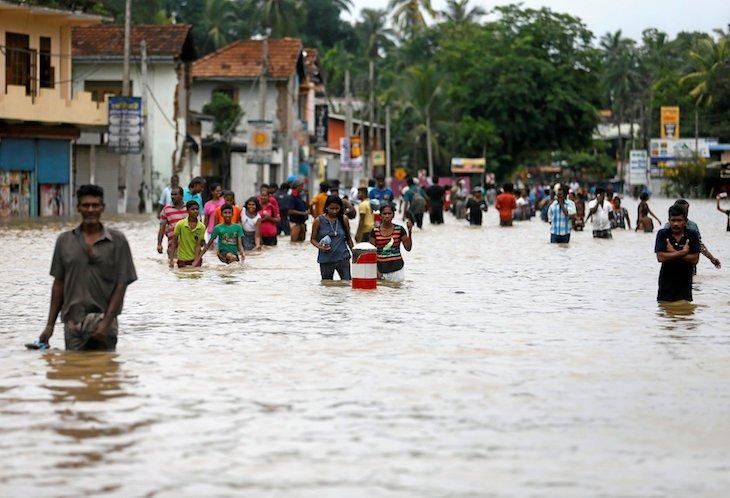

In [ ]:
# Display image which we want to predict
from IPython.display import Image
# Image(filename='/content/drive/MyDrive/DATA270/data_1/test/flood/904291469409878016_0.jpg', width=300,height=200)
Image(filename='/content/drive/MyDrive/DATA270/data_1/train/flood/870233018341797888_0.jpg', width=300,height=200)


In [ ]:
# Preprocess image and make prediction

preprocessed_image = preprocess_image('/870233018341797888_0.jpg')
predictions = model.predict(preprocessed_image)

1/1 [==============================] - 1s 703ms/step


In [ ]:
# Print predicted accuracy scores for both classes, i.e. (1) Flooding, (2) No Flooding
predictions

array([[0.5207078 , 0.55614567]], dtype=float32)

In [ ]:
# Get the maximum probability score for predicted class from predictions array
result = np.argmax(predictions)

In [ ]:
# Print the predicted class label
labels[result]

'No Flooding'

In [ ]:
# Prepare image for mobilenet prediction

def preprocess_image(file):
    img_path = '/content/drive/MyDrive/DATA270/data_1/test/non_flood'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

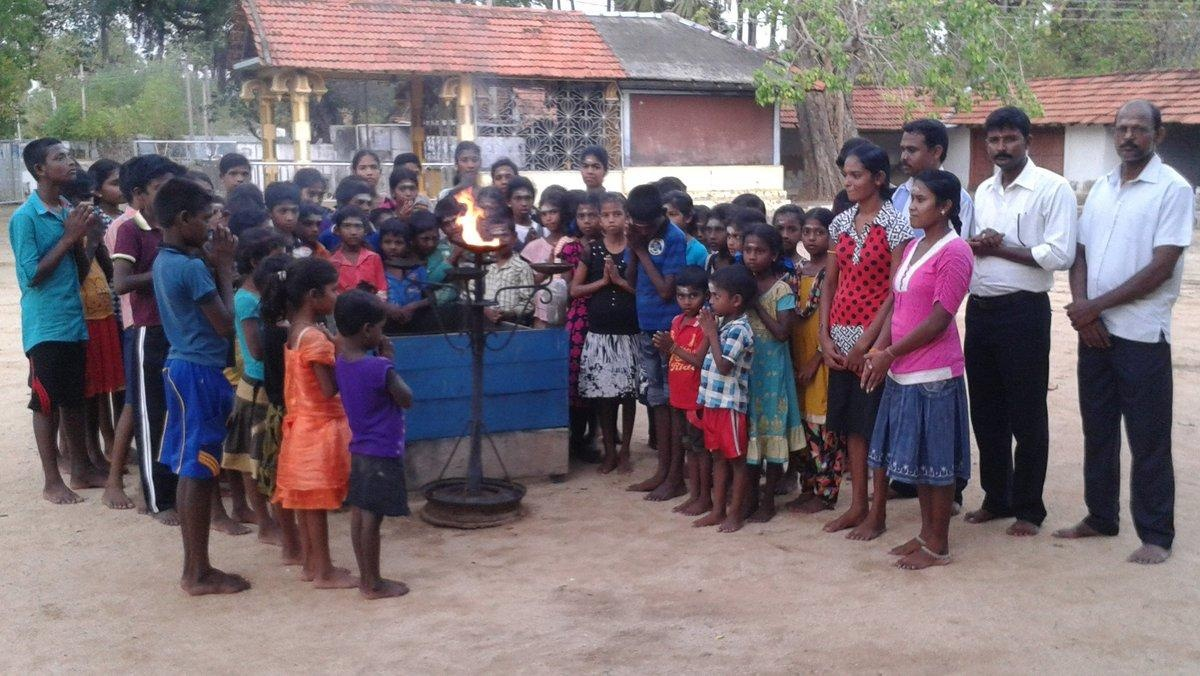

In [ ]:
# Display image which we want to predict
from IPython.display import Image
Image(filename='/content/drive/MyDrive/DATA270/data_1/test/non_flood/873258014953938945_1.jpg', width=300,height=200)

In [ ]:
# Preprocess image and make prediction

preprocessed_image = preprocess_image('/873258014953938945_1.jpg')
predictions = model.predict(preprocessed_image)

1/1 [==============================] - 0s 28ms/step


In [ ]:
# Print predicted accuracy scores for both classes, i.e. (1) Flooding, (2) No Flooding
predictions

array([[0.5199005, 0.5562829]], dtype=float32)

In [ ]:
# Get the maximum probability score for predicted class from predictions array
result = np.argmax(predictions)

In [ ]:
# Display image which we want to predict
from IPython.display import Image
Image(filename='/content/drive/MyDrive/DATA270/data_1/test/non_flood/873258014953938945_1.jpg', width=300,height=200)
labels[result]

In [ ]:
# Print the predicted class label
labels[result]

'No Flooding'